<h1>Importing libraries and setting the directory</h1>

In [9]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
%matplotlib notebook
import pickle
import statistics

current = os.getcwd()
data_dir = os.path.join(current, "Final")

<h1>Reading and plotting the data</h1>

<IPython.core.display.Javascript object>


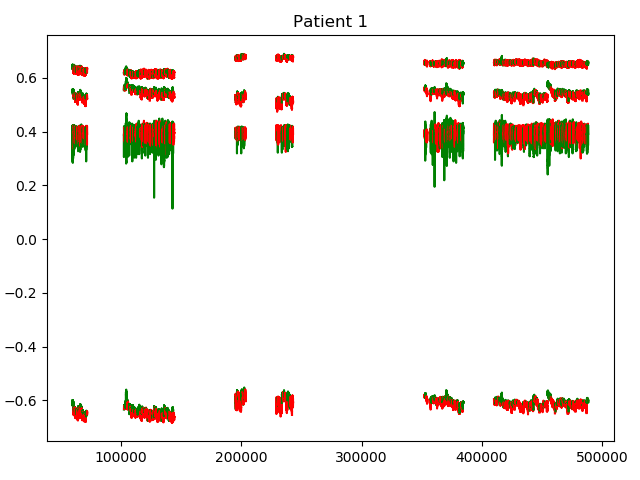

<IPython.core.display.Javascript object>


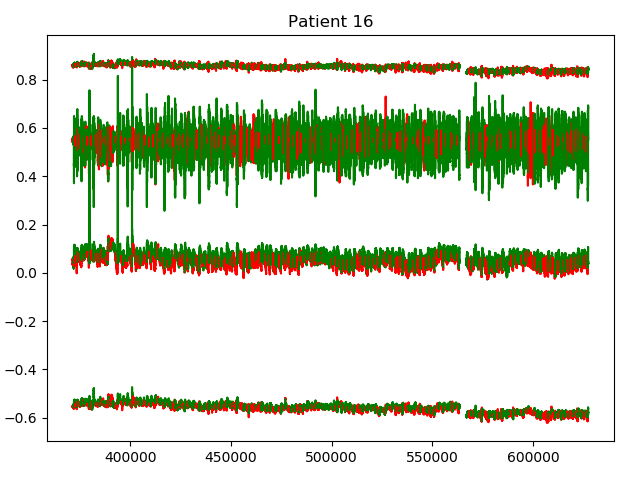

In [10]:
normal_count, obstr_count = 0, 0
accel_all, start_ind_all, end_ind_all, Y_all, end_ind_all, time_all  = [], [], [], [], [], []
test=[]
patients = []
count = 1234
for file in os.listdir(data_dir):
    
    #Patient number
    patient = int(re.findall(r'\d+', file)[0])
    patients.append(patient)
    
    #Change if analyzing different patients
    if (patient != 16 and patient != 1):
        continue
    path = os.path.join(data_dir, file)
    df = pd.read_csv(path, delimiter=',')
    
    #Reading the markers for inspirations starts, ends and classes
    start, end, obstr, normal = df["14 Memory"].values, df["15 Memory"].values, df["17 Memory"].values, df["16 Memory"].values
    can = df["Cannula"]
    can = ((can - can.min())/(can.max()-can.min()))*(5.0-(-0.1))+(-0.1)
    Y_pat = []
    obstr_count += sum(obstr)
    normal_count += sum(normal)
    start_ind = np.where(start == 1)[0]
    end_ind = np.where(end == 1)[0]
    
    #Reading the signal and taking the rolling mean of 5
    accel = df[['accel_x', 'accel_y','accel_z']]/-16384
    bs = df['breath_signal']
    bs = pd.DataFrame(bs)
    accel = accel.rolling(5).mean()[4:]
    bs = bs.rolling(5).mean()[4:]
    count += 1
    plt.figure(count)
    plt.title("Patient %d" % patient)
    plt.tight_layout()
    accel_pat, bs_pat, time_pat = [], [], []
    
    #Reaing each breath w.r.t. each marker
    e = 0
    for i in range(len(start_ind) - 1):
        if(start_ind[i] > end_ind[e]): e += 1
        if(start_ind[i+1] < end_ind[e]): e -= 1
          
        if (start_ind[i] < end_ind[e] and start_ind[i+1] > end_ind[e] and start_ind[i] != end_ind[e]):
            pre_breath = 0 if start_ind[i] < 5 else start_ind[i] - 5
            post_breath = end_ind[e]
            if(len(accel.iloc[start_ind[i]:start_ind[i+1]]) <= 300):
                if (sum(obstr[pre_breath:post_breath]) >= 1):
                    Y_pat.append(1)
                    accel_bs = pd.concat([accel.iloc[start_ind[i]:end_ind[e]], bs.iloc[start_ind[i]:end_ind[e]]], axis=1, sort=False)
                    accel_pat.append(accel_bs)
                    plt.plot(accel.iloc[start_ind[i]:start_ind[i+1]], '-r')
                    plt.plot(can.iloc[start_ind[i]:start_ind[i+1]], '-r')
                elif (sum(normal[pre_breath:post_breath]) >= 1):
                    Y_pat.append(0)
                    accel_bs = pd.concat([accel.iloc[start_ind[i]:end_ind[e]], bs.iloc[start_ind[i]:end_ind[e]]], axis=1, sort=False)
                    accel_pat.append(accel_bs)
                    plt.plot(accel.iloc[start_ind[i]:start_ind[i+1]], '-g')
                    plt.plot(can.iloc[start_ind[i]:start_ind[i+1]], '-g')
        e += 1 
    start_ind_all.append(start_ind)
    end_ind_all.append(end_ind)
    accel_all.append(accel_pat)
    Y_all.append(Y_pat)
    time_all.append(time_pat)

<h1>Scaling each breath to the same interval</h1>

<IPython.core.display.Javascript object>


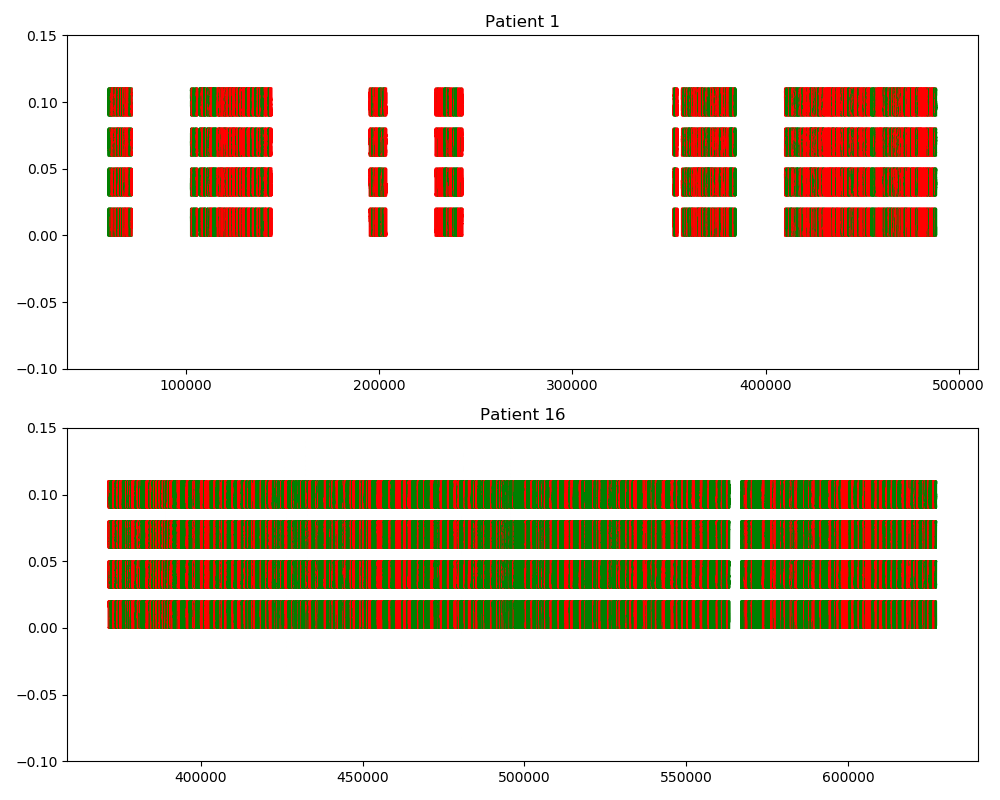

In [11]:
n = len(accel_all)
plt.figure(1, figsize=(10, 4*n))
count = 0
obst_all, normal_all, indet_all = [], [], []
for j in range(len(accel_all)):
    count += 1
    plt.subplot(n,1, count)
    obs, nor, ind = [], [], []
    for i in range(len(accel_all[j])):
        
        #Scaling
        new = accel_all[j][i]
        min_one = new.min()
        max_one = new.max()
        maxi = [0.3, 0.2, 0.2]
        mini = [0.2, 0.1, 0.0]
        accel_all[j][i] = (((new-min_one)/(max_one-min_one)) * (0.02))
        accel_all[j][i]["accel_x"] += 0.09
        accel_all[j][i]["accel_y"] += 0.06
        accel_all[j][i]["accel_z"] += 0.03
        
        #Plotting
        if(Y_all[j][i] == 1):
            plt.plot(accel_all[j][i], 'r-')
            obs.append(accel_all[j][i])
        elif(Y_all[j][i] == 0):
            plt.plot(accel_all[j][i], 'g-')
            nor.append(accel_all[j][i])
            
    obst_all.append(obs)
    normal_all.append(nor)
    plt.title("Patient %d" % patients[j])
    axes = plt.gca()
    axes.set_ylim([-0.1,0.15])
    plt.tight_layout()

<h1>Separating normal and obstructed breaths and plotting them nicely (ZOOM IN for analysis)</h1>

<IPython.core.display.Javascript object>


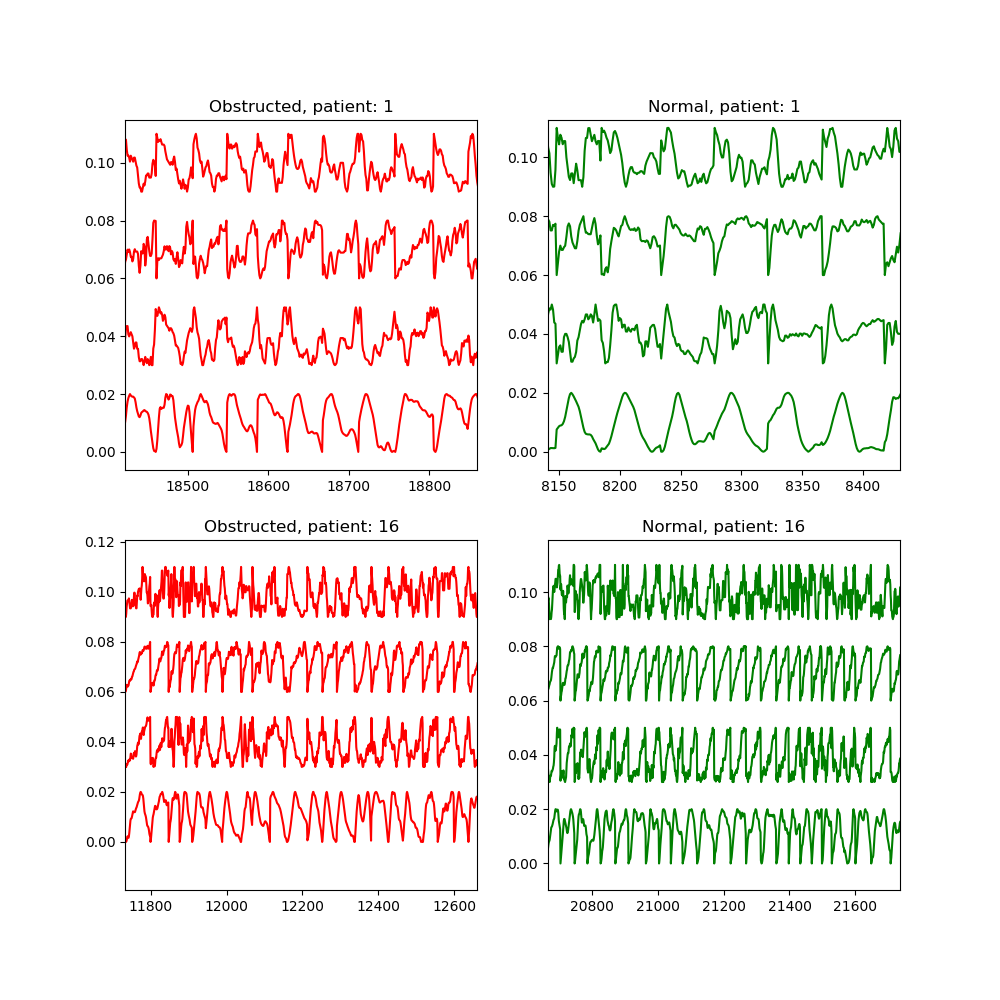

In [12]:
n=len(accel_all)
plt.figure(2, figsize=(10, 5*n))
m=1
for j in range(len(accel_all)):
    obst_all_mod = obst_all[j]
    normal_all_mod = normal_all[j]
    
    #Separating two classes
    for i in range(len(obst_all[j])):
        obst_all_mod[i] = obst_all[j][i]
    for i in range(len(normal_all[j])):
        normal_all_mod[i] = normal_all[j][i]
        
    #Plotting
    plt.subplot(n,2,m)
    red = pd.concat(obst_all_mod).reset_index(drop=True)
    plt.plot (red, '-r')
    axes = plt.gca()
    axes.set_ylim([-0.05,0.15])
    plt.title("Obstructed, patient: %d" %patients[j])

    plt.subplot(n,2,m+1)
    green = pd.concat(normal_all_mod).reset_index(drop=True)
    plt.plot (green, '-g')
    axes = plt.gca()
    axes.set_ylim([-0.05,0.15])
    plt.title("Normal, patient: %d" %patients[j])    
    m += 2


<h1>Finding the representative shapelets by taking the mean of resampled to the same length inspirations</h1>

<IPython.core.display.Javascript object>


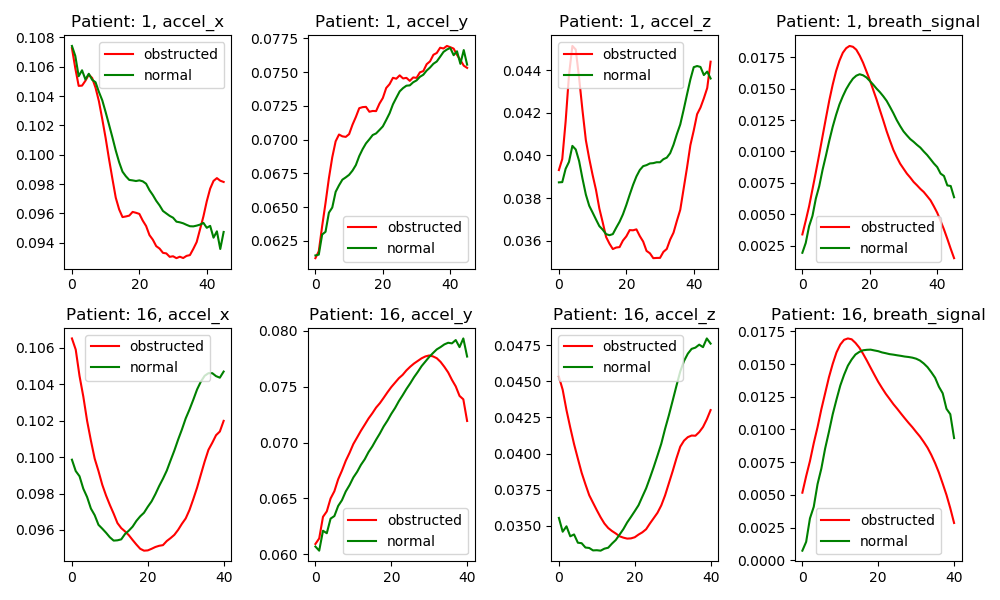

In [13]:
plt.figure (3, figsize=(10, 3*n))
k= 0
for j in range(len(accel_all)):  
    for a in ["accel_x", "accel_y", "accel_z", "breath_signal"]:
        k += 1
        plt.subplot(n, 4, k)
        resampled_insp_ob = []
        
        #Finding median lengths
        lengths_ob = [len(i) for i in obst_all[j]]
        lengths_nor = [len(i) for i in normal_all[j]]
        medlen = int(statistics.median(lengths_ob + lengths_nor))
        
        #Resampling each inspiration to the median length
        resampled_insp_ob = [signal.resample(i[a], medlen) for i in obst_all[j]]
        resampled_insp_nor = [signal.resample(i[a], medlen) for i in normal_all[j]]
        
        #Taking the eman of all resampled inspirations
        ob_avg = np.mean(resampled_insp_ob, axis=0)
        nor_avg = np.mean(resampled_insp_nor, axis=0)
        
        #Plotting
        plt.plot(ob_avg, 'r-', label='obstructed')
        plt.plot(nor_avg, 'g-', label='normal')
        plt.title('Patient: ' + str(patients[j]) + ", " + a )
        plt.legend()
        plt.tight_layout()